In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [15]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# import ipywidgets as widgets  # interactive display
# %config InlineBackend.figure_format='retina'
# use NMA plot style
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
# my_layout = widgets.Layout()

In [16]:
def my_raster_plot(range_t, spike_train, n):
    """Generates poisson trains

    Args:
      range_t     : time sequence
      spike_train : binary spike trains, with shape (N, Lt)
      n           : number of Poisson trains plot

    Returns:
      Raster_plot of the spike train
    """

    # Find the number of all the spike trains
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
        print('The number n exceeds the size of spike trains')
        print('The number n is set to be the size of spike trains')
        n = N

    # Raster plot
    i = 0
    while i <= n:
        if spike_train[i, :].sum() > 0.:
            t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
            plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n + 0.5])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.show()


def my_example_P(pre_spike_train_ex, pars, P):
    """Generates two plots (raster plot and LTP vs time plot)

    Args:
      pre_spike_train_ex     : spike-train
      pars : dictionary with the parameters
      P : LTP ratio

    Returns:
      my_example_P returns a rastert plot (top),
      and a LTP ratio across time (bottom)
    """
    spT = pre_spike_train_ex
    plt.figure(figsize=(7, 6))
    plt.subplot(211)
    color_set = ['red', 'blue', 'black', 'orange', 'cyan']
    for i in range(spT.shape[0]):
        t_sp = pars['range_t'][spT[i, :] > 0.5]   # spike times
        plt.plot(t_sp, i*np.ones(len(t_sp)), '|',
                 color=color_set[i],
                 ms=10, markeredgewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.xlim(0, 200)

    plt.subplot(212)
    for k in range(5):
        plt.plot(pars['range_t'], P[k, :], color=color_set[k], lw=1.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('P(t)')
    plt.xlim(0, 200)

    plt.tight_layout()
    plt.show()


def mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW):
    plt.figure()
    plt.plot([-5 * tau_stdp, 5 * tau_stdp], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

    plt.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'ro')
    plt.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'bo')

    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
    plt.ylabel(r'$\Delta$W', fontsize=12)
    plt.title('Biphasic STDP', fontsize=12, fontweight='bold')
    plt.show()

In [17]:
def default_pars_STDP(**kwargs):
    pars = {}

    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['V_init'] = -65.   # initial potential [mV]
    pars['V_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)

    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.                   # STDP time constant [ms]

    # simulation parameters
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]

    # external parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

    return pars


def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains

    Args:
      pars            : parameter dictionary
      rate            : noise amplitute [Hz]
      n               : number of Poisson trains
      myseed          : random seed. int or boolean

    Returns:
      pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)
    """

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

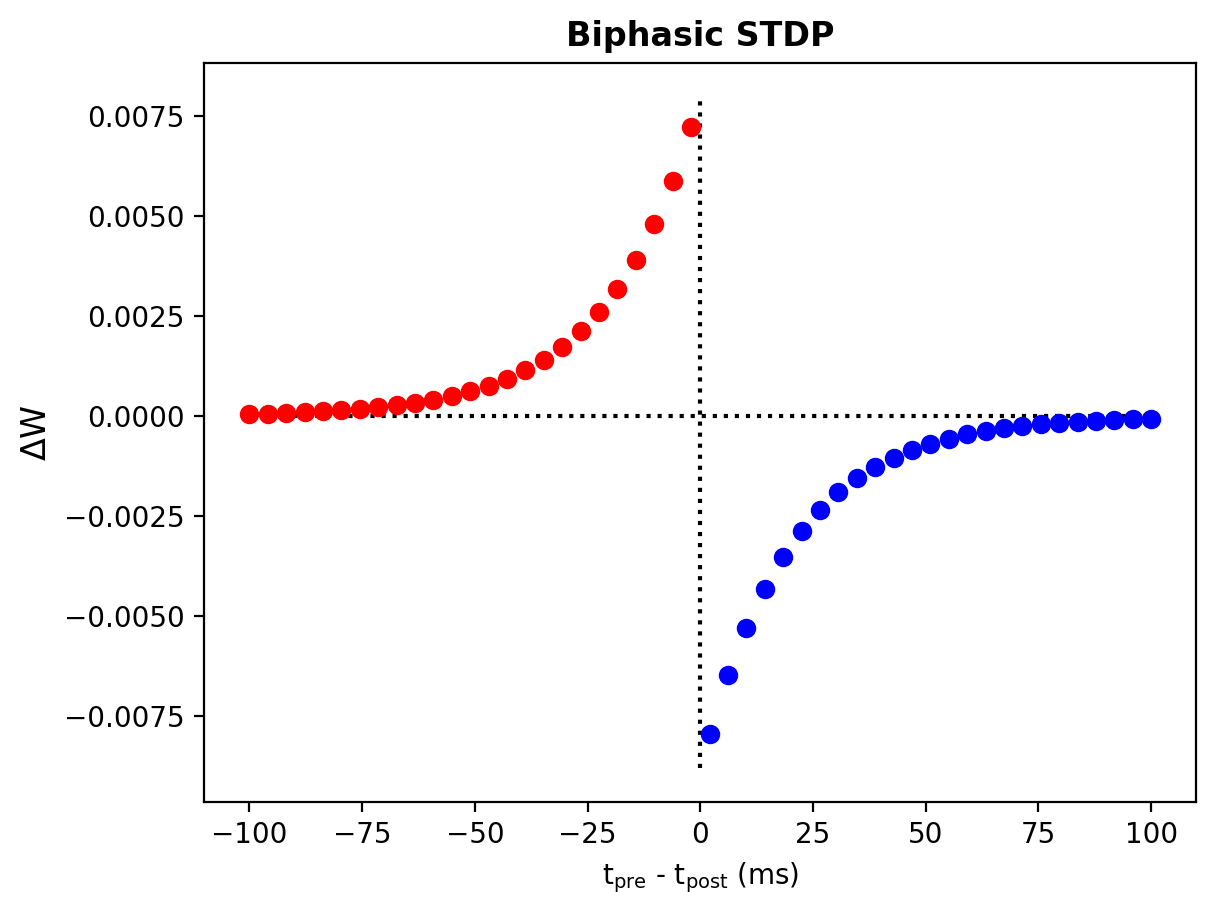

In [19]:
def Delta_W(pars, A_plus, A_minus, tau_stdp):
    """
    Plot STDP biphasic exponential decaying function

    Args:
      pars       : parameter dictionary
      A_plus     : (float) maximum amount of synaptic modification
                   which occurs when the timing difference between pre- and
                   post-synaptic spikes is positive
      A_minus    : (float) maximum amount of synaptic modification
                   which occurs when the timing difference between pre- and
                   post-synaptic spikes is negative
      tau_stdp   : the ranges of pre-to-postsynaptic interspike intervals
                   over which synaptic strengthening or weakening occurs

    Returns:
      dW         : instantaneous change in weights
    """

    # STDP change
    dW = np.zeros(len(time_diff))
    # Calculate dW for LTP
    dW[time_diff <= 0] = A_plus * np.exp(time_diff[time_diff <= 0] / tau_stdp)
    # Calculate dW for LTD
    dW[time_diff > 0] = -A_minus * np.exp(-time_diff[time_diff > 0] / tau_stdp)

    return dW


pars = default_pars_STDP()
# Get parameters
A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
# pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 50)

dW = Delta_W(pars, A_plus, A_minus, tau_stdp)
mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW)

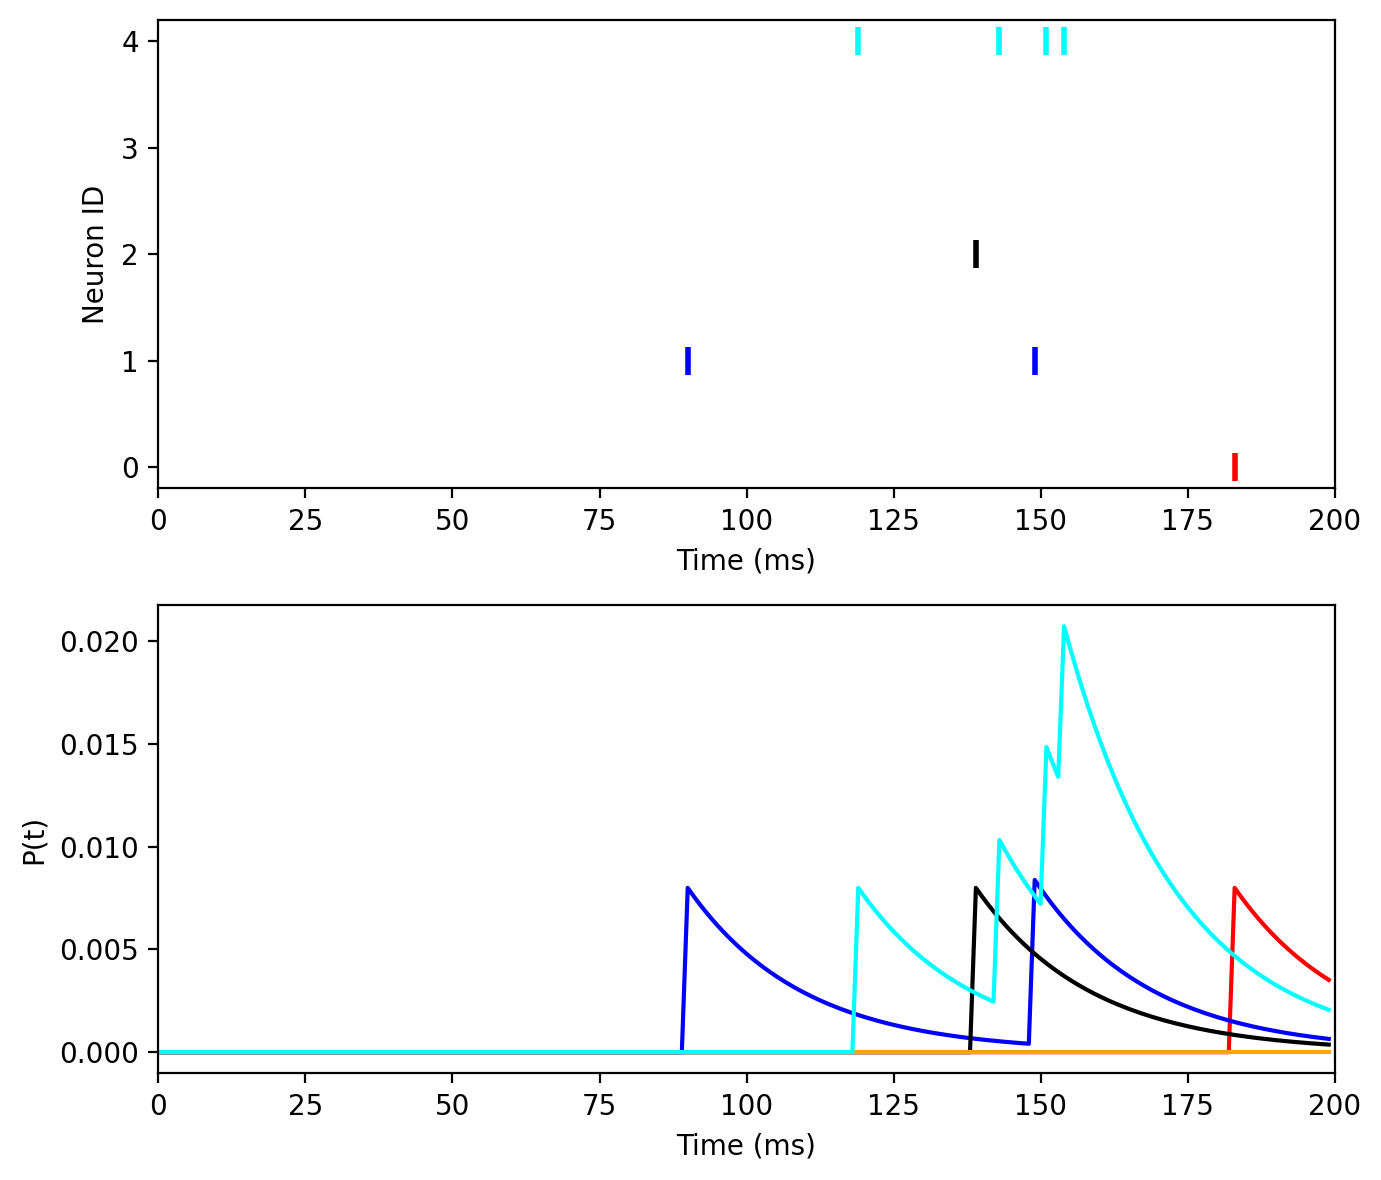

In [20]:
def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes

    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : binary spike train input from
                           presynaptic excitatory neuron

    Returns:
      P                  : LTP ratio
    """

    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
        # Calculate the delta increment dP
        dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
        # Update P
        P[:, it + 1] = P[:, it] + dP

    return P


pars = default_pars_STDP(T=200., dt=1.)
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=5, myseed=2020)
P = generate_P(pars, pre_spike_train_ex)

my_example_P(pre_spike_train_ex, pars, P)

In [8]:
def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    """
    conductance-based LIF dynamics

    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron

    Returns:
      rec_spikes         : spike times
      rec_v              : mebrane potential
      gE                 : postsynaptic excitatory conductance
    """

    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_minus, tau_stdp = pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    P = generate_P(pars, pre_spike_train_ex)

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value

    # simulation
    rec_spikes = []  # recording spike times
    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1
        elif v[it] >= V_th:   # reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it] * gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref / dt

        # update the synaptic conductance
        M[it + 1] = M[it] - dt / tau_stdp * M[it]
        gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + (gE_bar_update[:, it] * pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it + 1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it + 1] < 0
        gE_bar_update[id_temp, it + 1] = 0.

        # calculate the increment of the membrane potential
        dv = (-(v[it] - V_L) - gE[it + 1] * (v[it] - VE)) * (dt / tau_m)

        # update membrane potential
        v[it + 1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, P, M, gE_bar_update

print(help(run_LIF_cond_STDP))

Help on function run_LIF_cond_STDP in module __main__:

run_LIF_cond_STDP(pars, pre_spike_train_ex)
    conductance-based LIF dynamics
    
    Args:
      pars               : parameter dictionary
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    
    Returns:
      rec_spikes         : spike times
      rec_v              : mebrane potential
      gE                 : postsynaptic excitatory conductance

None


In [9]:
pars = default_pars_STDP(T=200., dt=1.)  # Simulation duration 200 ms
pars['gE_bar'] = 0.024                   # max synaptic conductance
pars['gE_init'] = 0.024                  # initial synaptic conductance
pars['VE'] = 0.                          # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.                   # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars,
                                                           pre_spike_train_ex)

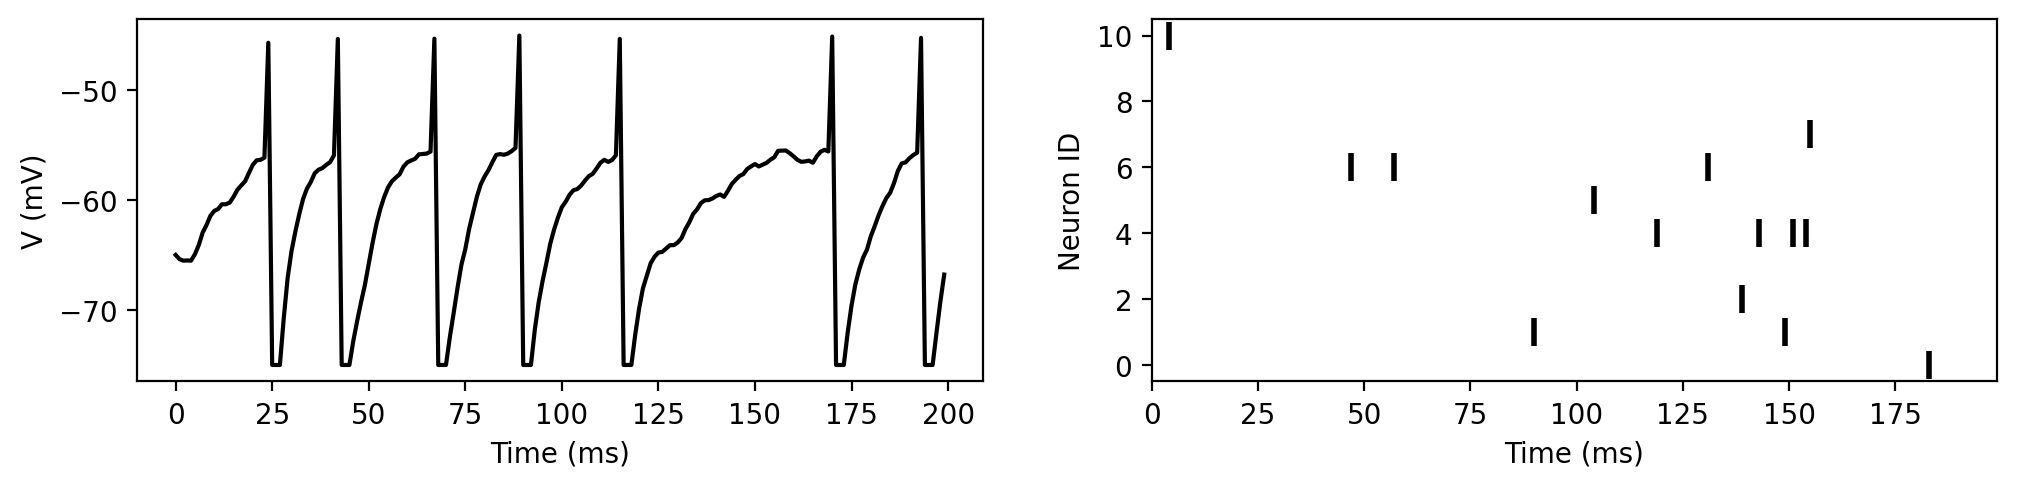

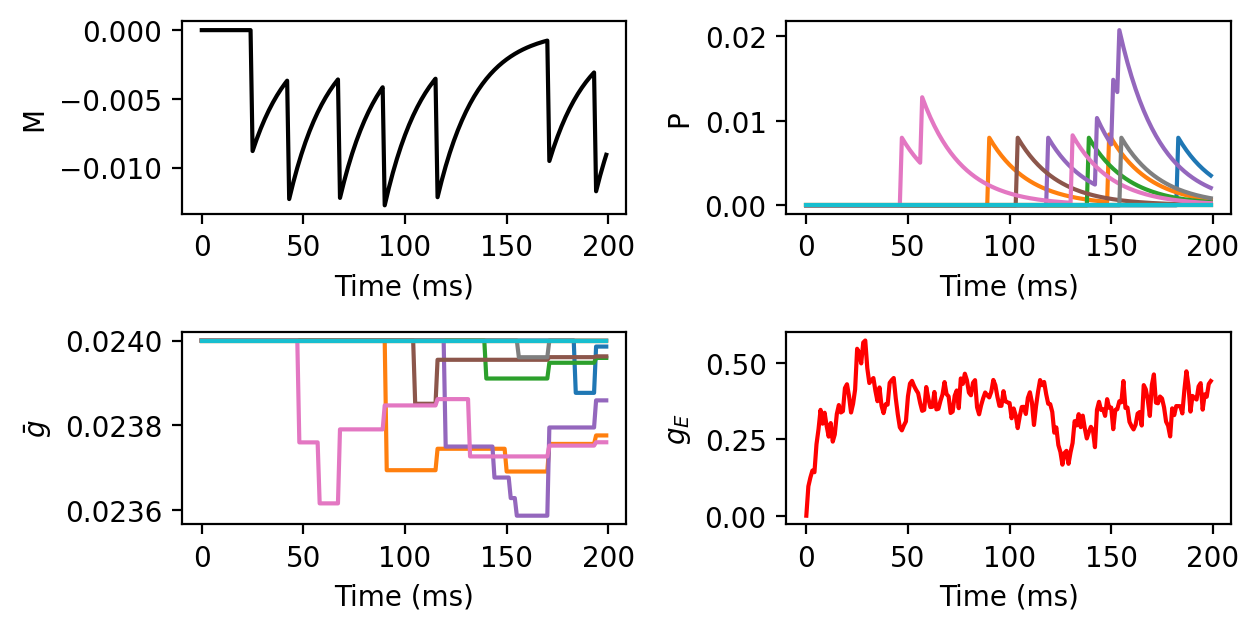

In [10]:
plt.figure(figsize=(12., 8))
plt.subplot(321)
dt, range_t = pars['dt'], pars['range_t']
if rec_spikes.size:
    sp_num = (rec_spikes / dt).astype(int) - 1
    v[sp_num] += 10   # add artificial spikes
plt.plot(pars['range_t'], v, 'k')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')

plt.subplot(322)
# Plot the sample presynaptic spike trains
my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)

plt.subplot(323)
plt.plot(pars['range_t'], M, 'k')
plt.xlabel('Time (ms)')
plt.ylabel('M')

plt.subplot(324)
for i in range(10):
    plt.plot(pars['range_t'], P[i, :])
plt.xlabel('Time (ms)')
plt.ylabel('P')

plt.subplot(325)
for i in range(10):
    plt.plot(pars['range_t'], gE_bar_update[i, :])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\bar g$')

plt.subplot(326)
plt.plot(pars['range_t'], gE, 'r')
plt.xlabel('Time (ms)')
plt.ylabel(r'$g_E$')

plt.tight_layout()
plt.show()